In [1]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

In [2]:
class Bandits():
    def __init__(self, k, mu, sigma):
        self.k = k
        self.means = np.random.normal(mu, sigma, k)
        self.variances = np.ones(k)
        self._step = 0
        self.state = None

    def reset(self):
        """
        return (observation, reward, terminated, truncated, info)
        """
        self._step = 0
        self.state = None
        return self._get_obs(), 0, False, False, self._get_info(),  # observation, reward, terminated, truncated, info

    def _get_obs(self):
        return self.state

    def _get_info(self):
        return {"steps": self._step}

    def get_optimal_action(self):
        return np.argmax(self.means)

    def step(self, action: int):
        """
        input: action
        return (observation, reward, terminated, truncated, info)
        """
        self._step += 1
        reward = np.random.normal(self.means[action], self.variances[action])
        return self._get_obs(), reward, True, False, self._get_info()


class Bandits_one(Bandits):
    def __init__(self):
        self.k = 3
        self.means = np.array([1, 2, 3])
        self.variances = np.ones(len(self.means))
        self._step = 0
        self.state = None


class Bandits_two(Bandits):
    def __init__(self):
        self.k = 4
        self.means = np.array([1, 2, 3, 2.5])
        self.variances = np.ones(len(self.means))
        self._step = 0
        self.state = None


class Bandits_three(Bandits):
    def __init__(self):
        self.k = 3
        self.means = np.array([2, 1.5, 2.2])
        self.variances = np.array([1, 1, 3])
        self._step = 0
        self.state = None


class Bandits_four(Bandits):
    def __init__(self, gene: int = 0):
        self.k = 3
        self.means = {0: np.array([1, 2, 2.2]),
                      1: gene * np.array([3, 1, 2.2])}
        self.variances = np.array([1, 1, 3])
        self.state = gene

    def reset(self):
        """
        return (observation, reward, terminated, truncated, info)
        """
        self._step = 0
        return self._get_obs(), 0, False, False, self._get_info(),  # observation, reward, terminated, truncated, info

    def step(self, action: int):
        """
        input: action
        return (observation, reward, terminated, truncated, info)
        """
        self._step += 1
        reward = np.random.normal(self.means[self.state][action], self.variances[action])
        return self._get_obs(), reward, True, False, self._get_info()

    def get_optimal_action(self):
        return np.argmax(self.means[self.state])

In [3]:
def epsilon_greedy(mab, T, epsilon):
    est_vals = np.zeros(mab.k)
    action_counts = np.zeros(mab.k)
    total_reward = 0
    regrets = np.zeros(T)

    for t in range(T):
        if np.random.rand() < epsilon:
            action = np.random.choice(mab.k)  # exploration
        else:
            action = np.argmax(est_vals)  # exploitation

        _, reward, _, _, _ = mab.step(action)
        optimal_action = mab.get_optimal_action()
        _, optimal_reward, _, _, _ = mab.step(optimal_action)
        regret = optimal_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]  # online upd formula for the exp value
        total_reward += reward
        regrets[t] = regret if t == 0 else regrets[t - 1] + regret  # cumulative regret

    return est_vals, total_reward, regrets


def decaying_epsilon_greedy(mab, T, epsilon, alpha):
    # est_vals = np.full(mab.k, init_estimate) # optimistic init
    est_vals = np.zeros(mab.k)
    action_counts = np.zeros(mab.k)
    total_reward = 0
    eps = epsilon
    regrets = np.zeros(T)

    for t in range(T):
        if np.random.rand() < eps:
            action = np.random.choice(mab.k)
        else:
            action = np.argmax(est_vals)

        _, reward, _, _, _ = mab.step(action)
        optimal_action = mab.get_optimal_action()
        _, optimal_reward, _, _, _ = mab.step(optimal_action)
        regret = optimal_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]
        total_reward += reward
        eps *= alpha
        regrets[t] = regret if t == 0 else regrets[t - 1] + regret

    return est_vals, total_reward, regrets


def ucb(mab, T, c):
    est_vals = np.zeros(mab.k)
    action_counts = np.zeros(mab.k) + 1e-10  # avoid div by zero
    total_reward = 0
    regrets = np.zeros(T)

    for t in range(1, T + 1):
        confidence_bound = c * np.sqrt(2 * np.log(t) / action_counts)
        action = np.argmax(est_vals + confidence_bound)

        _, reward, _, _, _ = mab.step(action)
        optimal_action = mab.get_optimal_action()
        _, optimal_reward, _, _, _ = mab.step(optimal_action)
        regret = optimal_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]
        total_reward += reward
        regrets[t - 1] = regret if t == 1 else regrets[t - 2] + regret

    return est_vals, total_reward, regrets

In [4]:
steps = 1000
num_runs = 20
epsilon = 0.3
alpha = 0.99
c = 2

In [5]:
def run_algorithms(mab, steps, epsilon, alpha, c):
    est_vals_eps_greedy, total_reward_eps_greedy, _ = epsilon_greedy(mab, steps, epsilon)
    est_vals_dec_eps_greedy, total_reward_dec_eps_greedy, _ = decaying_epsilon_greedy(mab, steps, epsilon, alpha)
    est_vals_ucb, total_reward_ucb, _ = ucb(mab, steps, c)

    return [
        ["Epsilon-Greedy", *est_vals_eps_greedy, total_reward_eps_greedy],
        ["Decaying Epsilon-Greedy", *est_vals_dec_eps_greedy, total_reward_dec_eps_greedy],
        ["UCB", *est_vals_ucb, total_reward_ucb],
    ]

In [6]:
def run_averaged(mab, num_runs, steps, k, epsilon, alpha, c):
    avg_regrets_eps_greedy = np.zeros(steps)
    avg_regrets_dec_eps_greedy = np.zeros(steps)
    avg_regrets_ucb = np.zeros(steps)

    avg_est_vals_eps_greedy = np.zeros(k)
    avg_est_vals_dec_eps_greedy = np.zeros(k)
    avg_est_vals_ucb = np.zeros(k)

    for _ in range(num_runs):
        mab = mab

        est_vals_eps_greedy, total_reward_eps_greedy, regrets_eps_greedy = epsilon_greedy(mab, steps, epsilon)
        est_vals_dec_eps_greedy, total_reward_dec_eps_greedy, regrets_dec_eps_greedy = decaying_epsilon_greedy(mab,
                                                                                                               steps,
                                                                                                               epsilon,
                                                                                                               alpha)
        est_vals_ucb, total_reward_ucb, regrets_ucb = ucb(mab, steps, c)

        avg_regrets_eps_greedy += regrets_eps_greedy
        avg_regrets_dec_eps_greedy += regrets_dec_eps_greedy
        avg_regrets_ucb += regrets_ucb

        avg_est_vals_eps_greedy += est_vals_eps_greedy
        avg_est_vals_dec_eps_greedy += est_vals_dec_eps_greedy
        avg_est_vals_ucb += est_vals_ucb

    avg_regrets_eps_greedy /= num_runs
    avg_regrets_dec_eps_greedy /= num_runs
    avg_regrets_ucb /= num_runs

    avg_est_vals_eps_greedy /= num_runs
    avg_est_vals_dec_eps_greedy /= num_runs
    avg_est_vals_ucb /= num_runs

    return [
        ["Epsilon-Greedy", *avg_est_vals_eps_greedy, np.mean(total_reward_eps_greedy)],
        ["Decaying Epsilon-Greedy", *avg_est_vals_dec_eps_greedy, np.mean(total_reward_dec_eps_greedy)],
        ["UCB", *avg_est_vals_ucb, np.mean(total_reward_ucb)],
    ], [avg_regrets_eps_greedy, avg_regrets_dec_eps_greedy, avg_regrets_ucb]

In [7]:
def plot_avg_cumulative_regret(avg_regrets, mab_name):
    plt.plot(avg_regrets[0], color="yellowgreen", label="Epsilon-Greedy")
    plt.plot(avg_regrets[1], color="cornflowerblue", label="Decaying Epsilon-Greedy")
    plt.plot(avg_regrets[2], color="palevioletred", label="UCB")
    plt.xlabel("Steps")
    plt.ylabel("Avg Cumulative Regret")
    plt.title(f"[{mab_name}]\nAvg Cumulative Regret of Epsilon-Greedy, Decaying\nEpsilon-Greedy and UCB")
    plt.legend()
    plt.show()

# Bandit 1

In [8]:
mab1 = Bandits_one()
headers_mab1 = ["Algorithm", "Est. Value 1", "Est. Value 2", "Est. Value 3", "Total Reward"]
data_mab1 = run_algorithms(mab1, steps, epsilon, alpha, c)
print(tabulate(data_mab1, headers=headers_mab1, tablefmt="simple"))

Algorithm                  Est. Value 1    Est. Value 2    Est. Value 3    Total Reward
-----------------------  --------------  --------------  --------------  --------------
Epsilon-Greedy                 0.753265         2.14251         2.92704         2599.81
Decaying Epsilon-Greedy        0.88608          1.95446         3.01187         2971.59
UCB                            0.50015          2.14193         2.95293         2890.32


In [9]:
headers_avg_mab1 = ["Algorithm", "Avg Est. Value 1", "Avg Est. Value 2", "Avg Est. Value 3", "Avg Total Reward"]
data_avg_mab1, plot_avg_regrets_mab1 = run_averaged(Bandits_one(), num_runs, steps, 3, epsilon, alpha, c)
print(tabulate(data_avg_mab1, headers=headers_avg_mab1, tablefmt="simple"))

Algorithm                  Avg Est. Value 1    Avg Est. Value 2    Avg Est. Value 3    Avg Total Reward
-----------------------  ------------------  ------------------  ------------------  ------------------
Epsilon-Greedy                     0.97768              2.01815             2.99781             2688.43
Decaying Epsilon-Greedy            1.04421              2.01454             3.00708             2957.45
UCB                                0.890571             1.95066             2.99829             2939.73


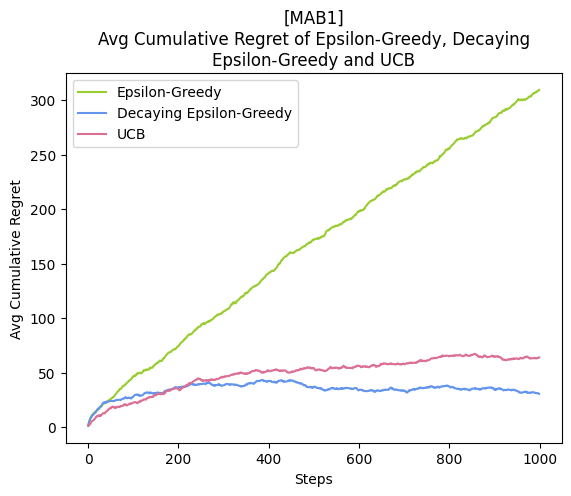

In [10]:
plot_avg_cumulative_regret(plot_avg_regrets_mab1, "MAB1")

# Bandit 2

In [11]:
mab2 = Bandits_two()
headers_mab2 = ["Algorithm", "Est. Value 1", "Est. Value 2", "Est. Value 3", "Est. Value 4", "Total Reward"]
data_mab2 = run_algorithms(mab2, steps, epsilon, alpha, c)
print(tabulate(data_mab2, headers=headers_mab2, tablefmt="simple"))

Algorithm                  Est. Value 1    Est. Value 2    Est. Value 3    Est. Value 4    Total Reward
-----------------------  --------------  --------------  --------------  --------------  --------------
Epsilon-Greedy                 1.00174          2.1361          2.98746         2.49665         2709.96
Decaying Epsilon-Greedy        0.952319         1.92989         2.94023         2.45429         2900.47
UCB                            1.23738          2.12123         2.97243         2.54283         2858.29


In [12]:
headers_avg_mab2 = ["Algorithm", "Avg Est. Value 1", "Avg Est. Value 2", "Avg Est. Value 3", "Avg Est. Value 4",
                    "Avg Total Reward"]
data_avg_mab2, plot_avg_regrets_mab2 = run_averaged(Bandits_two(), num_runs, steps, 4, epsilon, alpha, c)
print(tabulate(data_avg_mab2, headers=headers_avg_mab2, tablefmt="simple"))

Algorithm                  Avg Est. Value 1    Avg Est. Value 2    Avg Est. Value 3    Avg Est. Value 4    Avg Total Reward
-----------------------  ------------------  ------------------  ------------------  ------------------  ------------------
Epsilon-Greedy                     1.01914              2.01946             2.99589             2.50879             2724.02
Decaying Epsilon-Greedy            1.022                1.99105             2.98782             2.3926              2941.79
UCB                                0.930674             1.98719             2.99916             2.48213             2880.93


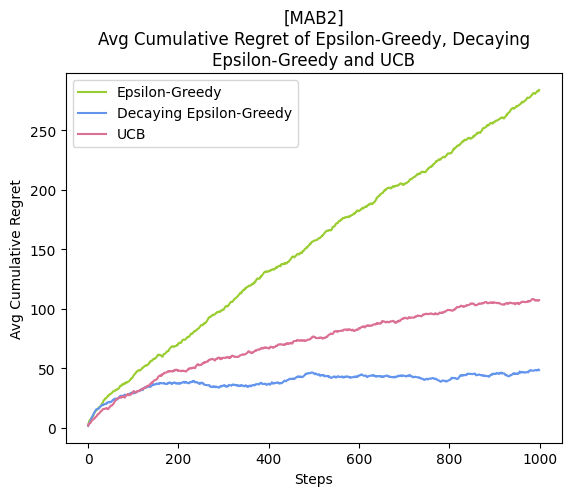

In [13]:
plot_avg_cumulative_regret(plot_avg_regrets_mab2, "MAB2")

# Bandit 3

In [14]:
mab3 = Bandits_three()
headers_mab3 = ["Algorithm", "Est. Value 1", "Est. Value 2", "Est. Value 3", "Total Reward"]
data_mab3 = run_algorithms(mab3, steps, epsilon, alpha, c)
print(tabulate(data_mab3, headers=headers_mab3, tablefmt="simple"))

Algorithm                  Est. Value 1    Est. Value 2    Est. Value 3    Total Reward
-----------------------  --------------  --------------  --------------  --------------
Epsilon-Greedy                  2.00802         1.4252          2.09032         1912.65
Decaying Epsilon-Greedy         1.70801         1.23226         2.26609         2238.14
UCB                             2.07952         1.0267          2.11161         2064.49


In [15]:
headers_avg_mab3 = ["Algorithm", "Avg Est. Value 1", "Avg Est. Value 2", "Avg Est. Value 3", "Avg Total Reward"]
data_avg_mab3, plot_avg_regrets_mab3 = run_averaged(Bandits_three(), num_runs, steps, 3, epsilon, alpha, c)
print(tabulate(data_avg_mab3, headers=headers_avg_mab3, tablefmt="simple"))

Algorithm                  Avg Est. Value 1    Avg Est. Value 2    Avg Est. Value 3    Avg Total Reward
-----------------------  ------------------  ------------------  ------------------  ------------------
Epsilon-Greedy                      1.99262             1.48101             2.10778             2190.81
Decaying Epsilon-Greedy             1.90948             1.34506             1.85106             2186.05
UCB                                 1.99501             1.43686             2.11531             2044.5


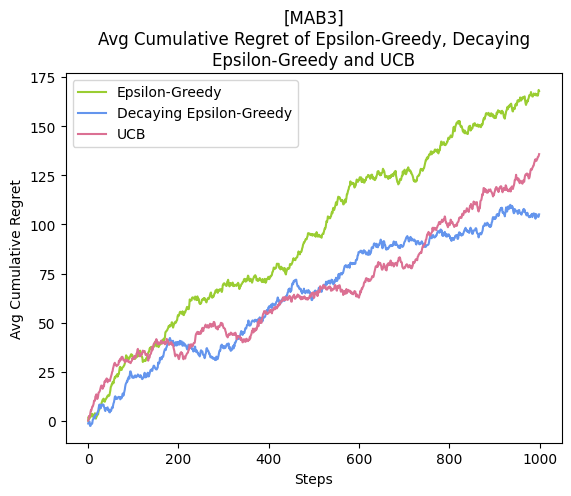

In [16]:
plot_avg_cumulative_regret(plot_avg_regrets_mab3, "MAB3")